In [1]:
import pandas as pd
import numpy as np
import os

os.listdir('./data')

['TCGA_binary.csv',
 'TCGA_data.csv',
 'urine_binary.csv',
 'urine_k15_0419.csv',
 'urine_K15_0420.csv',
 'urine_k15_0423.csv',
 'urine_k15_0428.csv',
 'urine_k15_120cases.csv']

In [2]:
TCGA = pd.read_csv('./data/TCGA_data.csv')
urine = pd.read_csv('./data/urine_k15_120cases.csv')

In [3]:
urine.shape

(116, 789)

In [4]:
urine.y.value_counts()

BLCA_15k    42
NL_15k      28
RCC_100k    23
PRAD_15k    23
Name: y, dtype: int64

In [5]:
TCGA = TCGA[(TCGA.y == 'BLCA') | (TCGA.y == 'Normal')]
TCGA = TCGA.replace(['BLCA','Normal'],[ 1,0 ])
TCGA = TCGA.reset_index(drop = True)

In [6]:
urine.drop(['Unnamed: 0','X'], axis = 1, inplace = True)
urine = urine[(urine.y == 'BLCA_15k') | (urine.y == 'NL_15k')]
urine = urine.replace(['BLCA_15k','NL_15k'],[ 1,0 ])
urine = urine.reset_index(drop = True)

In [7]:
urine.columns

Index(['cyto.1p36.33', 'cyto.1p36.32', 'cyto.1p36.31', 'cyto.1p36.23',
       'cyto.1p36.22', 'cyto.1p36.21', 'cyto.1p36.13', 'cyto.1p36.12',
       'cyto.1p36.11', 'cyto.1p35.3',
       ...
       'cyto.9p21.1', 'cyto.9p13.3', 'cyto.9p13.2', 'cyto.9p13.1', 'cyto.9p12',
       'cyto.9p11.2', 'cyto.9p11.1', 'cyto.9q11', 'cyto.9q12', 'y'],
      dtype='object', length=787)

# wrong index

In [8]:
urine.y.value_counts()

1    42
0    28
Name: y, dtype: int64

# Scaling

In [9]:
TCGA.y.value_counts()

0    1706
1     408
Name: y, dtype: int64

In [10]:
X = TCGA.drop('y', axis = 1)
y = TCGA['y']

urine_X = urine.drop('y', axis = 1)
urine_y = urine['y']

In [11]:
urine.columns

Index(['cyto.1p36.33', 'cyto.1p36.32', 'cyto.1p36.31', 'cyto.1p36.23',
       'cyto.1p36.22', 'cyto.1p36.21', 'cyto.1p36.13', 'cyto.1p36.12',
       'cyto.1p36.11', 'cyto.1p35.3',
       ...
       'cyto.9p21.1', 'cyto.9p13.3', 'cyto.9p13.2', 'cyto.9p13.1', 'cyto.9p12',
       'cyto.9p11.2', 'cyto.9p11.1', 'cyto.9q11', 'cyto.9q12', 'y'],
      dtype='object', length=787)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

standardsc = StandardScaler()
mms = MinMaxScaler()
mas = MaxAbsScaler()

standardsc.fit(X)
mms.fit(X)
mas.fit(X)

X_standard = pd.DataFrame(standardsc.transform(X), columns = X.columns)
X_mms = pd.DataFrame(mms.transform(X), columns = X.columns)
X_mas = pd.DataFrame(mas.transform(X), columns = X.columns)

urine_X_standard = standardsc.transform(urine_X)
urine_X_mms = mms.transform(urine_X)
urine_X_mas = mas.transform(urine_X)

C:\Users\wjssm\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

def get_eval(y_test, pred) :
    
    print('accuracy : {0:.4f} precision : {1:.4f} recall : {2:.4f} F1 : {3:.4f} AUC : {4:.4f}'.format(
                                                        accuracy_score(y_test, pred), 
                                                        precision_score(y_test, pred),
                                                        recall_score(y_test, pred),
                                                        f1_score(y_test,pred),
                                                        roc_auc_score(y_test, pred)
                                                                      ))
    
    
    
    #print('accuracy : {0:.4f}'.format(accuracy_score(y_test,pred)), 'roc_auc_score : ', roc_auc_score(y_test,pred))
    #print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))

In [14]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_prba_c1, thresholds) :
    
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_prba_c1)
        custom_predict = binarizer.transform(pred_prba_c1)
        
        print('threshold ; ', custom_threshold)
        get_eval(y_test, custom_predict)
        print('\n')

In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, random_state=0, shuffle = True)

In [16]:
def model_pipeline_2(model) :
    
    cv_acc = []
    cv_acc_sc = []
    cv_acc_mms = []
    cv_acc_mas = []

    for i, (tr_ind, te_ind) in enumerate(skf.split(X,y)) :

        X_train, X_test = X.iloc[tr_ind], X.iloc[te_ind]
        X_train_sc, X_test_sc = X_standard.iloc[tr_ind], X_standard.iloc[te_ind]
        X_train_mms, X_test_mms = X_mms.iloc[tr_ind], X_mms.iloc[te_ind]
        X_train_mas, X_test_mas = X_mas.iloc[tr_ind], X_mas.iloc[te_ind]
        
        y_train, y_test = y[tr_ind], y[te_ind]

        model.fit(X_train, y_train)
        cv_acc.append(accuracy_score(y[te_ind], model.predict(X_test)))
        
        model.fit(X_train_sc, y_train)
        cv_acc_sc.append(accuracy_score(y[te_ind], model.predict(standardsc.transform(X_test_sc))))
        
        model.fit(X_train_mms, y_train)
        cv_acc_mms.append(accuracy_score(y[te_ind], model.predict(mms.transform(X_test_mms))))
        
        model.fit(X_train_mas, y_train)
        cv_acc_mas.append(accuracy_score(y[te_ind], model.predict(mas.transform(X_test_mas))))
        
        print('{0} 번째 accuracy non_scale : {1:.4f}% StandardScale : {2:.4f}% MinMax : {3:.4f}% MaxAbs : {4:.4f}%'.format(i,cv_acc[i],cv_acc_sc[i],cv_acc_mms[i],cv_acc_mas[i]))

    print('\n mean accuracy non_scale : {0:.4f}% StandardScale : {1:.4f}% MinMax : {2:.4f}% MaxAbs : {3:.4f}%'.format(np.mean(cv_acc),np.mean(cv_acc_sc),np.mean(cv_acc_mms),np.mean(cv_acc_mas)))

In [17]:
#predict urine data using pipeline

def pipeline_urine(model) :
    
    model.fit(X,y)
    print('###non-scaled###')
    get_eval(urine_y, model.predict(urine_X))

    model.fit(X_standard,y)
    print('###StandardScaler###')
    get_eval(urine_y, model.predict(urine_X_standard))
    
    model.fit(X_mms,y)
    print('###MinMaxScaler###')
    get_eval(urine_y, model.predict(urine_X_mms))
    
    model.fit(X_mas,y)
    print('###MaxAbsScaler###')
    get_eval(urine_y, model.predict(urine_X_mas))

# logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
import warnings
warnings.filterwarnings('ignore')

In [28]:
model_pipeline_2(lr)

0 번째 accuracy non_scale : 0.9764% StandardScale : 0.9575% MinMax : 0.8868% MaxAbs : 0.9717%
1 번째 accuracy non_scale : 0.9905% StandardScale : 0.9693% MinMax : 0.8913% MaxAbs : 0.9882%
2 번째 accuracy non_scale : 0.9764% StandardScale : 0.9645% MinMax : 0.8700% MaxAbs : 0.9716%
3 번째 accuracy non_scale : 0.9834% StandardScale : 0.9597% MinMax : 0.8863% MaxAbs : 0.9810%
4 번째 accuracy non_scale : 0.9763% StandardScale : 0.9787% MinMax : 0.8981% MaxAbs : 0.9739%

 mean accuracy non_scale : 0.9806% StandardScale : 0.9659% MinMax : 0.8865% MaxAbs : 0.9773%


In [30]:
pipeline_urine(lr)

###non-scaled###
accuracy : 0.5000 precision : 1.0000 recall : 0.1667 F1 : 0.2857 AUC : 0.5833
[[28  0]
 [35  7]]
###StandardScaler###
accuracy : 0.5429 precision : 0.8571 recall : 0.2857 F1 : 0.4286 AUC : 0.6071
[[26  2]
 [30 12]]
###MinMaxScaler###
accuracy : 0.5714 precision : 0.9286 recall : 0.3095 F1 : 0.4643 AUC : 0.6369
[[27  1]
 [29 13]]
###MaxAbsScaler###
accuracy : 0.4857 precision : 0.8000 recall : 0.1905 F1 : 0.3077 AUC : 0.5595
[[26  2]
 [34  8]]


# randomforest

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20, random_state = 10)

In [38]:
model_pipeline_2(lr)

0 번째 accuracy non_scale : 0.9764% StandardScale : 0.9575% MinMax : 0.8868% MaxAbs : 0.9717%
1 번째 accuracy non_scale : 0.9905% StandardScale : 0.9693% MinMax : 0.8913% MaxAbs : 0.9882%
2 번째 accuracy non_scale : 0.9764% StandardScale : 0.9645% MinMax : 0.8700% MaxAbs : 0.9716%
3 번째 accuracy non_scale : 0.9834% StandardScale : 0.9597% MinMax : 0.8863% MaxAbs : 0.9810%
4 번째 accuracy non_scale : 0.9763% StandardScale : 0.9787% MinMax : 0.8981% MaxAbs : 0.9739%

 mean accuracy non_scale : 0.9806% StandardScale : 0.9659% MinMax : 0.8865% MaxAbs : 0.9773%


In [34]:
rf = RandomForestClassifier(n_estimators=20, random_state = 10)
pipeline_urine(rf)

###non-scaled###
accuracy : 0.6714 precision : 0.6508 recall : 0.9762 F1 : 0.7810 AUC : 0.5952
[[ 6 22]
 [ 1 41]]
###StandardScaler###
accuracy : 0.6714 precision : 0.6508 recall : 0.9762 F1 : 0.7810 AUC : 0.5952
[[ 6 22]
 [ 1 41]]
###MinMaxScaler###
accuracy : 0.6714 precision : 0.6508 recall : 0.9762 F1 : 0.7810 AUC : 0.5952
[[ 6 22]
 [ 1 41]]
###MaxAbsScaler###
accuracy : 0.6714 precision : 0.6508 recall : 0.9762 F1 : 0.7810 AUC : 0.5952
[[ 6 22]
 [ 1 41]]


# SVM

In [36]:
from sklearn.svm import SVC
svm = SVC(probability=True)

In [39]:
model_pipeline_2(svm)

0 번째 accuracy non_scale : 0.9623% StandardScale : 0.1934% MinMax : 0.8066% MaxAbs : 0.9505%
1 번째 accuracy non_scale : 0.9740% StandardScale : 0.1939% MinMax : 0.8085% MaxAbs : 0.9574%
2 번째 accuracy non_scale : 0.9527% StandardScale : 0.1939% MinMax : 0.8109% MaxAbs : 0.9385%
3 번째 accuracy non_scale : 0.9645% StandardScale : 0.1919% MinMax : 0.8128% MaxAbs : 0.9526%
4 번째 accuracy non_scale : 0.9692% StandardScale : 0.1919% MinMax : 0.8081% MaxAbs : 0.9550%

 mean accuracy non_scale : 0.9645% StandardScale : 0.1930% MinMax : 0.8094% MaxAbs : 0.9508%


In [37]:
pipeline_urine(svm)

###non-scaled###
accuracy : 0.5286 precision : 0.8000 recall : 0.2857 F1 : 0.4211 AUC : 0.5893
[[25  3]
 [30 12]]
###StandardScaler###
accuracy : 0.6000 precision : 0.6250 recall : 0.8333 F1 : 0.7143 AUC : 0.5417
[[ 7 21]
 [ 7 35]]
###MinMaxScaler###
accuracy : 0.4286 precision : 0.6667 recall : 0.0952 F1 : 0.1667 AUC : 0.5119
[[26  2]
 [38  4]]
###MaxAbsScaler###
accuracy : 0.5143 precision : 0.7857 recall : 0.2619 F1 : 0.3929 AUC : 0.5774
[[25  3]
 [31 11]]


# adaboost

In [40]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()

In [41]:
model_pipeline_2(ada)

0 번째 accuracy non_scale : 0.9858% StandardScale : 0.7736% MinMax : 0.1934% MaxAbs : 0.9670%
1 번째 accuracy non_scale : 0.9882% StandardScale : 0.9835% MinMax : 0.1939% MaxAbs : 0.9882%
2 번째 accuracy non_scale : 0.9716% StandardScale : 0.9716% MinMax : 0.1939% MaxAbs : 0.9740%
3 번째 accuracy non_scale : 0.9787% StandardScale : 0.1943% MinMax : 0.1919% MaxAbs : 0.9763%
4 번째 accuracy non_scale : 0.9834% StandardScale : 0.9692% MinMax : 0.1919% MaxAbs : 0.9858%

 mean accuracy non_scale : 0.9815% StandardScale : 0.7784% MinMax : 0.1930% MaxAbs : 0.9782%


In [42]:
ada.fit(X_mas,y)
thresholds = [0.3,0.4,0.45,0.47,0.5,0.55,0.6]
get_eval_by_threshold(urine_y, ada.predict_proba(urine_X_mas)[:,1].reshape(-1,1), thresholds)

threshold ;  0.3
accuracy : 0.6000 precision : 0.6000 recall : 1.0000 F1 : 0.7500 AUC : 0.5000
[[ 0 28]
 [ 0 42]]


threshold ;  0.4
accuracy : 0.6000 precision : 0.6000 recall : 1.0000 F1 : 0.7500 AUC : 0.5000
[[ 0 28]
 [ 0 42]]


threshold ;  0.45
accuracy : 0.6143 precision : 0.6154 recall : 0.9524 F1 : 0.7477 AUC : 0.5298
[[ 3 25]
 [ 2 40]]


threshold ;  0.47
accuracy : 0.6714 precision : 0.6610 recall : 0.9286 F1 : 0.7723 AUC : 0.6071
[[ 8 20]
 [ 3 39]]


threshold ;  0.5
accuracy : 0.6857 precision : 0.7083 recall : 0.8095 F1 : 0.7556 AUC : 0.6548
[[14 14]
 [ 8 34]]


threshold ;  0.55
accuracy : 0.5429 precision : 0.6667 recall : 0.4762 F1 : 0.5556 AUC : 0.5595
[[18 10]
 [22 20]]


threshold ;  0.6
accuracy : 0.3571 precision : 0.3846 recall : 0.1190 F1 : 0.1818 AUC : 0.4167
[[20  8]
 [37  5]]




# GBM

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

In [44]:
model_pipeline_2(gb)

0 번째 accuracy non_scale : 0.9858% StandardScale : 0.9717% MinMax : 0.1934% MaxAbs : 0.9764%
1 번째 accuracy non_scale : 0.9882% StandardScale : 0.9622% MinMax : 0.1939% MaxAbs : 0.9882%
2 번째 accuracy non_scale : 0.9764% StandardScale : 0.9716% MinMax : 0.1915% MaxAbs : 0.9716%
3 번째 accuracy non_scale : 0.9858% StandardScale : 0.9858% MinMax : 0.1919% MaxAbs : 0.9810%
4 번째 accuracy non_scale : 0.9834% StandardScale : 0.9550% MinMax : 0.1919% MaxAbs : 0.9882%

 mean accuracy non_scale : 0.9839% StandardScale : 0.9693% MinMax : 0.1925% MaxAbs : 0.9811%


In [45]:
pipeline_urine(gb)

###non-scaled###
accuracy : 0.6286 precision : 0.6250 recall : 0.9524 F1 : 0.7547 AUC : 0.5476
[[ 4 24]
 [ 2 40]]
###StandardScaler###
accuracy : 0.6286 precision : 0.6250 recall : 0.9524 F1 : 0.7547 AUC : 0.5476
[[ 4 24]
 [ 2 40]]
###MinMaxScaler###
accuracy : 0.6286 precision : 0.6250 recall : 0.9524 F1 : 0.7547 AUC : 0.5476
[[ 4 24]
 [ 2 40]]
###MaxAbsScaler###
accuracy : 0.6286 precision : 0.6250 recall : 0.9524 F1 : 0.7547 AUC : 0.5476
[[ 4 24]
 [ 2 40]]


# XGBoost

# LightGBM

In [18]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()

In [30]:
pipeline_urine(lgb)

###non-scaled###
accuracy : 0.6286 precision : 0.6212 recall : 0.9762 F1 : 0.7593 AUC : 0.5417
[[ 3 25]
 [ 1 41]]
###StandardScaler###
accuracy : 0.6571 precision : 0.6364 recall : 1.0000 F1 : 0.7778 AUC : 0.5714
[[ 4 24]
 [ 0 42]]
###MinMaxScaler###
accuracy : 0.6286 precision : 0.6212 recall : 0.9762 F1 : 0.7593 AUC : 0.5417
[[ 3 25]
 [ 1 41]]
###MaxAbsScaler###
accuracy : 0.6286 precision : 0.6212 recall : 0.9762 F1 : 0.7593 AUC : 0.5417
[[ 3 25]
 [ 1 41]]


In [19]:
lgb.fit(X_standard, y)
lgb_pred = lgb.predict(urine_X_standard)

In [20]:
import matplotlib.pyplot as plt

In [43]:
def roc_curve_plot(y_test, pred_proba_c1) :
    
    fpr, tpr, threshold = roc_curve(y_test, pred_proba_c1)
    
    #ROC curve
    plt.plot(fpr, tpr, label = 'ROC')
    #대각선 직선
    plt.plot([0,1],[0,1], 'k--', label = 'Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.xlabel('1-Specifity', fontsize = 16)
    plt.ylabel('Sensitivity',fontsize = 16)
    
    plt.legend(prop={'size': 15})

sample 10 thresholds :  [2.   1.   1.   1.   1.   1.   0.97 0.59]
sample FPR :  [0.    0.143 0.214 0.286 0.464 0.536 0.714 0.821]
sample TPR :  [0.    0.095 0.286 0.643 0.738 0.833 0.929 1.   ]


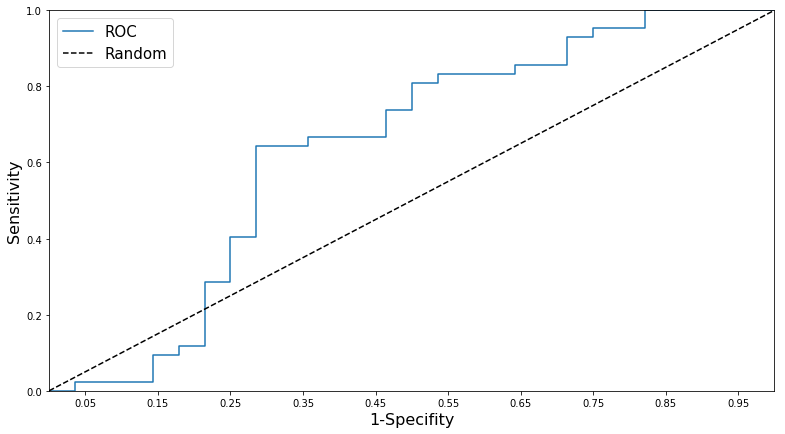

In [44]:
pred_proba = lgb.predict_proba(urine_X_standard)[:,1]
plt.figure(figsize = (13,7))
roc_curve_plot(urine_y, pred_proba)
plt.savefig("./lgb_roc.png",dpi=300)
fpr, tpr, threshold = roc_curve(urine_y, pred_proba)

#5step으로 추출
thr_index = np.arange(0, threshold.shape[0], 4)
print('sample 10 thresholds : ', np.round(threshold[thr_index],2))
print('sample FPR : ', np.round(fpr[thr_index],3))
print('sample TPR : ', np.round(tpr[thr_index],3))

In [35]:
def roc_info_print(fpr, tpr) :
    
    mysum = 1 - fpr + tpr
    max_sum_ind = np.argmax(mysum)
    
    print('max sum : ', np.max(mysum))
    print('specifity : ', 1 - fpr[max_sum_ind])
    print('sensitivity : ', tpr[max_sum_ind])

In [36]:
roc_info_print(fpr, tpr)

max sum :  1.3571428571428572
specifity :  0.7142857142857143
sensitivity :  0.6428571428571429


## wrong predict id

실제 BC중에

In [61]:
lgb_pred[:42]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)